In [ ]:
!pip install 'ray[tune]'
!pip install nevergrad

In [ ]:
from google.colab import drive
%cd /content/drive/MyDrive/fellowshipai_challenge/

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import itertools
from PIL import Image
import time
import os
import copy
from collections import Counter
from functools import partial

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils, models
from torchvision.datasets.folder import pil_loader
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from scipy.io import loadmat

import cv2

from ray import tune
from ray.tune.suggest.nevergrad import NevergradSearch
from ray.tune import JupyterNotebookReporter
from ray.tune.schedulers import ASHAScheduler
import nevergrad as ng

# Credit to kazuto1011 for this implementation: https://github.com/kazuto1011/grad-cam-pytorch
from grad_cam_pytorch import GradCAM

/content/drive/MyDrive/fellowshipai_challenge


# Problem Definition

Goal: Use a pretrained ResNet 34 and train on the Cars dataset and then visualize the layer activations using GRADCAM for a mislabeled image of your weakest class. Improve the model without increasing the number of epochs.

This can be achieved in a few different ways:
- Fine-tuning the hyper-parameters of ResNet
- Feature Engineering
- Use GRADCAM to visualize where the CNN is extracting features from and crop or change the image if it is activating in the wrong regions 


In this notebook, I will apply each of these improvements and some combination of them. I will then compare them based on the accuracy achieved by each model. I believe this is the best metric to compare the models since this is a fine-grained classification problem. 

The SOTA benchmarks for the Cars dataset are: 

Model | Benchmark Accuracy
------|----------
T-Resnet | 96.3%
Dat | 96.2%
ResNet-101 | 91.2%

The rest of the rankings can be found at: https://paperswithcode.com/sota/fine-grained-image-classification-on-stanford

I included the top 2 rankings and the only ranking for a pure ResNet CNN because this shows the total upper bound for how accurate the model can be as well as the upper bound for a pure ResNet architecture. There is no ranking for a ResNet-34 model unfortunately, but I can gauge how well my model is doing compared to the ResNet-101 benchmark. If my model scores above it then I'm a genius or something is wrong. Probably the latter.

# Step 0: Getting the Data

In [ ]:
def parse_annotations(mat_file, cols):
    
    annots = loadmat(mat_file)
    
    annot_names = list(annots.keys())[3:] # skip metadata info
    
    df = pd.DataFrame(columns = cols)
    
    for annotations in annots[annot_names[0]][0]:
        
        *arr, name = list(itertools.chain(*annotations)) # unpacks the array of arrays
        unpacked_arr = list(itertools.chain(*arr)) # unpacks the other array of arrays
        unpacked_arr.append(name) # concatenates it all into a list
        
        tmp = pd.DataFrame([unpacked_arr], columns=cols)
        
        df = df.append(tmp)
    
    return df

data_columns = ['bbox_x1', 'bbox_x2', 'bbox_y1', 'bbox_y2', 'class', 'fname']

names = loadmat('./devkit/cars_meta.mat')

classes = list(itertools.chain(*names['class_names'][0])) # makes a list of all class names
train_df = parse_annotations('./devkit/cars_train_annos.mat', cols=data_columns)
test_df = parse_annotations('./cars_test_annos_withlabels.mat', cols=data_columns)

In [ ]:
display(train_df, test_df, classes)

bbox_x1 bbox_x2 bbox_y1 bbox_y2 class      fname
0       39     116     569     375    14  00001.jpg
0       36     116     868     587     3  00002.jpg
0       85     109     601     381    91  00003.jpg
0      621     393    1484    1096   134  00004.jpg
0       14      36     133      99   106  00005.jpg
..     ...     ...     ...     ...   ...        ...
0        3      44     423     336    78  08140.jpg
0      138     150     706     523   196  08141.jpg
0       26     246     660     449   163  08142.jpg
0       78     526    1489     908   112  08143.jpg
0       20     240     862     677    17  08144.jpg

[8144 rows x 6 columns]

bbox_x1 bbox_x2 bbox_y1 bbox_y2 class      fname
0       30      52     246     147   181  00001.jpg
0      100      19     576     203   103  00002.jpg
0       51     105     968     659   145  00003.jpg
0       67      84     581     407   187  00004.jpg
0      140     151     593     339   185  00005.jpg
..     ...     ...     ...     ...   ...        ...
0       49      57    1169     669    63  08037.jpg
0       23      18     640     459    16  08038.jpg
0       33      27     602     252    17  08039.jpg
0       33     142     521     376    38  08040.jpg
0       77      73     506     380    32  08041.jpg

[8041 rows x 6 columns]

['AM General Hummer SUV 2000',
 'Acura RL Sedan 2012',
 'Acura TL Sedan 2012',
 'Acura TL Type-S 2008',
 'Acura TSX Sedan 2012',
 'Acura Integra Type R 2001',
 'Acura ZDX Hatchback 2012',
 'Aston Martin V8 Vantage Convertible 2012',
 'Aston Martin V8 Vantage Coupe 2012',
 'Aston Martin Virage Convertible 2012',
 'Aston Martin Virage Coupe 2012',
 'Audi RS 4 Convertible 2008',
 'Audi A5 Coupe 2012',
 'Audi TTS Coupe 2012',
 'Audi R8 Coupe 2012',
 'Audi V8 Sedan 1994',
 'Audi 100 Sedan 1994',
 'Audi 100 Wagon 1994',
 'Audi TT Hatchback 2011',
 'Audi S6 Sedan 2011',
 'Audi S5 Convertible 2012',
 'Audi S5 Coupe 2012',
 'Audi S4 Sedan 2012',
 'Audi S4 Sedan 2007',
 'Audi TT RS Coupe 2012',
 'BMW ActiveHybrid 5 Sedan 2012',
 'BMW 1 Series Convertible 2012',
 'BMW 1 Series Coupe 2012',
 'BMW 3 Series Sedan 2012',
 'BMW 3 Series Wagon 2012',
 'BMW 6 Series Convertible 2007',
 'BMW X5 SUV 2007',
 'BMW X6 SUV 2012',
 'BMW M3 Coupe 2012',
 'BMW M5 Sedan 2010',
 'BMW M6 Convertible 2010',
 'BMW X3

# Step 1: Creating a Baseline Model

In [ ]:
# Class to convert dataframe to dataset and perform transformations
class Dataset(Dataset):
    
    def __init__(self, df, transform=None, bbox=True, train=True):
        
        self.labels = df['class'].values # convert DataFrame into Numpy arrays
        self.img_names = df['fname'].values
        self.transform = transform
        self.train = train
        
        if bbox:
            self.bbox = df.loc[:, 'bbox_x1':'bbox_y2'].values
        
    def __len__(self):
        
        return len(self.img_names)
    
    def __getitem__(self, index):
        
        img_name = self.img_names[index]
        
        if self.train:
            X = pil_loader('/content/drive/My Drive/fellowshipai_challenge/data/cars_train/'+img_name)
        else:
            X = pil_loader('/content/drive/My Drive/fellowshipai_challenge/data/cars_test/'+img_name)
        
        bbox = self.bbox[index]
        
        bbox_X = X.crop(tuple(bbox)) # crop the image around the car
        
        y = self.labels[index]
        
        if self.transform:
            X = self.transform(bbox_X)
        
        return X, y, img_name

In [ ]:
# transform the image to adhere to the model (input>=224x224 and normalized)
transformations = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# make batch variable to make it easier to change
batch = 32

# split dataset into train and validation
dataset = train_df
train, val = train_test_split(dataset, test_size=0.2, random_state=42, 
                              shuffle=True, stratify=dataset['class'])

# create PyTorch dataset and dataloader for model
train_dataset = Dataset(train, transform=transformations)
val_dataset = Dataset(val, transform=transformations)

train_dataloader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch, shuffle=True)

dataloaders = {'train':train_dataloader,
               'val':val_dataloader}

dataset_sizes = {'train': len(train),
                 'val': len(val)}

device = torch.device('cuda:0' if torch.cuda.is_available() else"cpu") 

torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 224, 224])


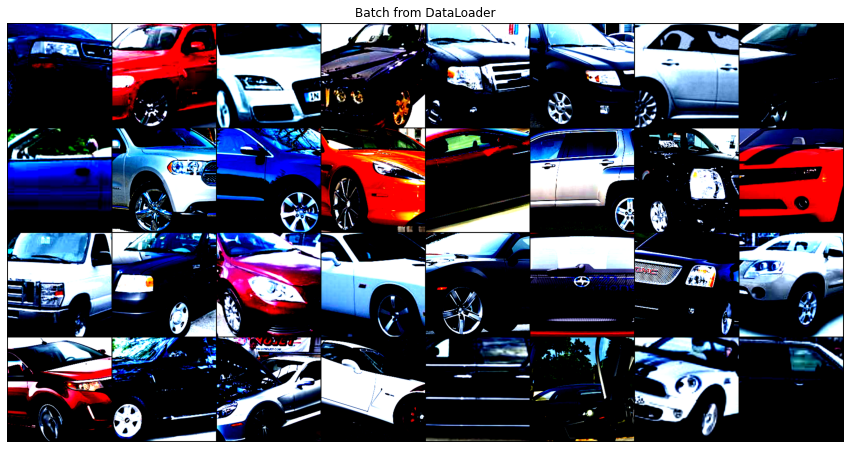

In [ ]:
def show_batch(batch):
    
    grid = utils.make_grid(batch)
    plt.imshow(grid.numpy().transpose(1, 2, 0))
    plt.title('Batch from DataLoader')

for i_batch, sample_batched in enumerate(train_dataloader):
    print(sample_batched[0].shape)
    if i_batch == 3:
        plt.figure(figsize=(15,8))
        show_batch(sample_batched[0])
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

Already one aspect that could be changed to improve the model is seen: how the images are cropped for the model. The ResNet-34 model can accept images that are at least 224x224 and larger by changing the FC layer to be large enough to process the new features. However, if the image is too big then the network will not be able to reduce the size via pooling or strided convolutions and will not be able to learn discriminative properties of the images. 

There is also the issue of making the images too large and running out of memory when processing the batches. This can be remediated by making the batches smaller, but causes the model to train for a longer time.

As can be seen from this first batch though, learning the features of the car model may be hard if it only shows one headlight or a door of the car. 

This is the perfect type of problem which can be solved using GradCAM. By observing where the layers are activating, we can see if it can learn discriminative properties despite text being in the photo or if using a small crop of the photo is not enough to find properties. 

## Creating the training function

In [ ]:
# Using training function from pytorch transfer learning
def train_model(model, criterion, optimizer, scheduler, dataloader,
                dataset_size, num_epochs=len(train_df)//batch):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-'*15)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels, _ in dataloader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                  
                # multiply by batch size since CrossEntropy is reduced using
                # the mean
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_size[phase]
            epoch_acc = running_corrects.double() / dataset_size[phase]
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}' + '\n')
                  
            if phase == 'val' and epoch_acc > best_acc:
                  best_acc = epoch_acc
                  best_model_wts = copy.deepcopy(model.state_dict())
                  torch.save(model.state_dict(), './best_model_params/model_ft_tune')
                  
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Val Acc: {best_acc:.4f}')
                  
    model.load_state_dict(best_model_wts)
    return model

### Training all layers of model

In [ ]:
model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(classes)+1)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs = 25)

Epoch 0/24
---------------
train Loss: 5.1611 Acc: 0.0261

val Loss: 4.7678 Acc: 0.0773

Epoch 1/24
---------------
train Loss: 4.2287 Acc: 0.2100

val Loss: 4.0525 Acc: 0.1952

Epoch 2/24
---------------
train Loss: 3.3634 Acc: 0.4264

val Loss: 3.4434 Acc: 0.3069

Epoch 3/24
---------------
train Loss: 2.5919 Acc: 0.6183

val Loss: 2.9197 Acc: 0.4279

Epoch 4/24
---------------
train Loss: 1.9104 Acc: 0.7721

val Loss: 2.5356 Acc: 0.4819

Epoch 5/24
---------------
train Loss: 1.3287 Acc: 0.8763

val Loss: 2.2275 Acc: 0.5384

Epoch 6/24
---------------
train Loss: 0.9005 Acc: 0.9431

val Loss: 2.0391 Acc: 0.5605

Epoch 7/24
---------------
train Loss: 0.5896 Acc: 0.9834

val Loss: 2.0114 Acc: 0.5770

Epoch 8/24
---------------
train Loss: 0.5517 Acc: 0.9868

val Loss: 2.0095 Acc: 0.5807

Epoch 9/24
---------------
train Loss: 0.5254 Acc: 0.9896

val Loss: 1.9908 Acc: 0.5844

Epoch 10/24
---------------
train Loss: 0.4983 Acc: 0.9899

val Loss: 1.9812 Acc: 0.5844

Epoch 11/24
--------

For the baseline model, I decided to train the model and update all of the weights in the model. This has the risk of overfitting which seems to have occurred based on how the training accuracy reached 99% while the best validation accuracy reached 59%. I believe that this establishes a good baseline though because I am able to see how the model performs when it is trained only for this classification task.

Now I will train the ConvNet as a fixed feature extractor and freeze the network except for the final layers to create a baseline for a model which only uses the last few layers.

# Step 2: Finetuning the model

In [ ]:
class Gradcam:
  
  def __init__(self, model, dataloader, dataset=val, images_df=None,
               sample_images=None):

    self.model = model
    self.images_df = images_df
    self.dataloader = dataloader
    self.dataset = dataset
    self.sample_images = sample_images

  def find_worst_class(self, dataloader_name, samples=2):
      
      # set model to eval mode
      self.model.eval()

      preds = []
      label = []
      mislabeled = []

      # get predictions for dataset
      for inputs, labels, name in self.dataloader[dataloader_name]:
        
        with torch.no_grad():
          out = self.model(inputs.to(device))
          _, prediction = torch.max(out, 1)
          preds.append(prediction.cpu().numpy())
          label.append(labels.cpu().numpy())

          if prediction != label:
            mislabeled.append(name)


      # concatenate all the batches
      pred = np.hstack(preds)
      true = np.hstack(label)
      mislabeled = np.hstack(mislabeled)

      # get array of only misclassifed classes
      mask = (pred != true)
      misclassified = pred[mask]

      # get the worst class
      worst_class = max(Counter(misclassified), key=Counter(misclassified).get)
      
      print(f'The worst class is {worst_class} or the {classes[worst_class]}.')

      # get images which belong to the worst class
      self.images_df = self.dataset[self.dataset['class'] == worst_class]
      self.images_df = self.images_df[self.images_df['fname'].isin(mislabeled)]

      # sample random images from it
      self.sample_images = self.images_df.sample(samples)

      return worst_class, pred, true, mislabeled


  def gradcam(self, target_layers, target_class, 
              grad_transformation, model_transformation):

    fname = self.sample_images.fname
    
    # must have dataset class to use
    sampled_images = [img for img, _, _ in Dataset(self.sample_images, 
                                        transform=model_transformation)]

    images = torch.stack(tuple(sampled_images)).to(device)

    gcam = GradCAM(model=self.model, candidate_layers=target_layers)
    
    probs, ids = gcam.forward(images)
    
    ids_ = torch.LongTensor([[target_class]] * len(images)).to(device)
    
    gcam.backward(ids=ids_)
    
    raw_images = [np.array(img) for img, _, _ in 
                  Dataset(self.sample_images, transform = grad_transformation)]
    
    for layer in target_layers:
      
      regions = gcam.generate(target_layer=layer)

      for j in range(len(images)):

        heatmap = regions[j,...].cpu().numpy().squeeze()

        # ellipses is saying to select all values from first two dimension then only the first 3 dimension
        cmap = cm.jet_r(heatmap)[..., :3] * 255.0 

        superimposed_img = (cmap.astype(np.float)+ raw_images[j].astype(np.float))/2
        cv2.imwrite(f'./heatmaps/{j}_resnet34_{layer}_{target_class}_{fname.iloc[j]}', np.uint8(superimposed_img))


def loadImages(path, class_num, graph=True):

  imagesList = os.listdir(path)

  if len(class_num) > 1:

    image_names = []
    for i in range(len(class_num)):

      r = re.compile(f'.*_{class_num[i]}_*')
      image_names.extend(list(filter(r.match, imagesList)))
  
  else:
    
    r = re.compile(f'.*_{class_num[0]}_*')
    image_names = list(filter(r.match, imagesList))

  loadedImages = [cv2.imread(path+image) for image in image_names]

  if graph:
    fig, ax = plt.subplots(len(loadedImages), 1, figsize=(10,len(loadedImages)*10))

    for i in range(len(loadedImages)):

      ax[i].set_title(image_names[i])
      ax[i].imshow(loadedImages[i])

  return loadedImages

## Using GradCAM to improve the model

### Looking at the activations for retrained ResNet model

In [ ]:
 # model loaded from baseline model
best_model_1_ft = models.resnet34(pretrained=True)
num_ftrs = best_model_1_ft.fc.in_features
best_model_1_ft.fc = nn.Linear(num_ftrs, len(classes)+1)
best_model_1_ft = best_model_1_ft.to(device)

best_model_1_ft.load_state_dict(torch.load('./best_model_params/model_ft_1'))

<All keys matched successfully>

In [ ]:
gradcam_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224)
  ])

gradcam = Gradcam(best_model_1_ft, dataloader=dataloaders)

worst_class, preds, labels, names = gradcam.find_worst_class('val')

gradcam.gradcam(target_layers=['layer4'], target_class=worst_class, 
                grad_transformation=gradcam_transform, model_transformation=transformations)

The worst class is 30 or the BMW 6 Series Convertible 2007.


Note: After retraining the model, the worst class changed to the BMW 6. Since it still has a similar look as the other luxury cars, then my analysis stands the same.

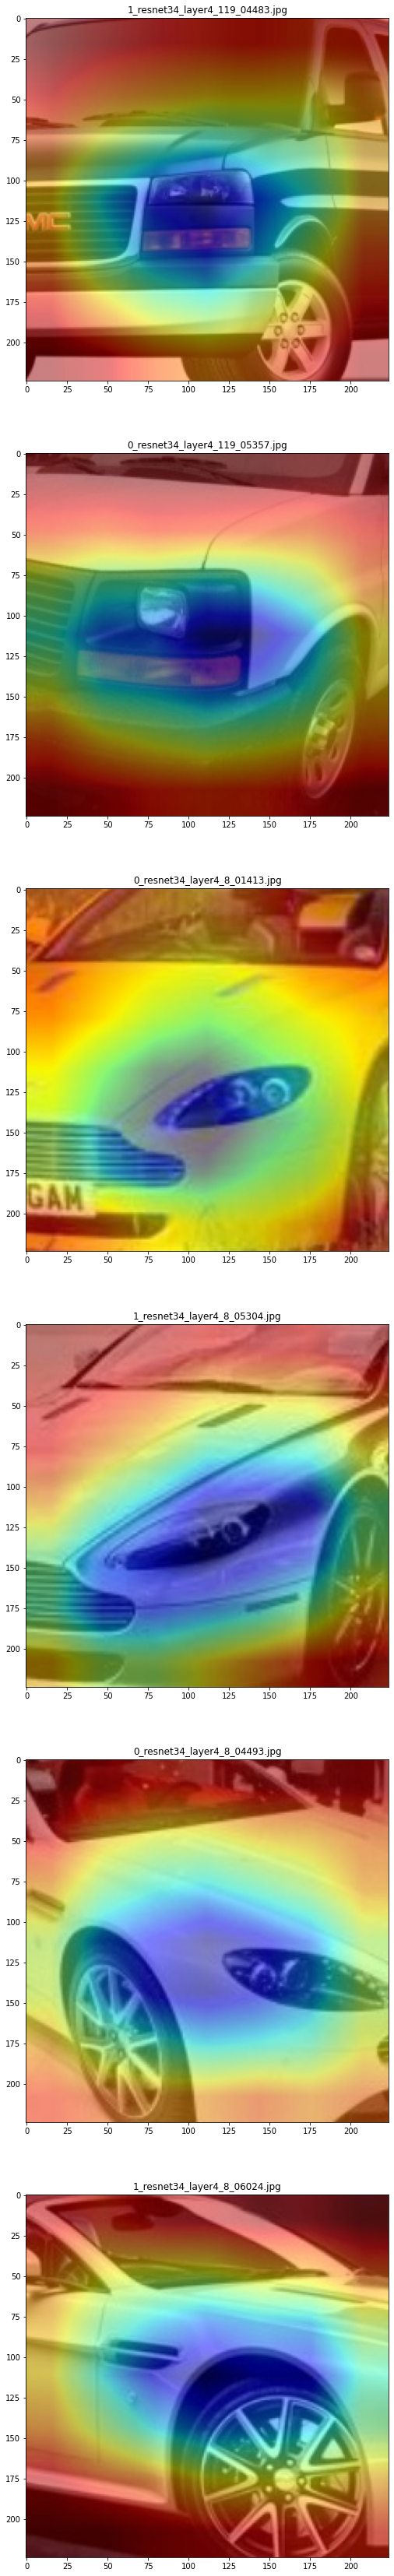

In [ ]:
imgs = loadImages('./heatmaps/')

It looks like the class which was most misclassified was the Aston Martin. This is interesting because the Aston Martin has a very unique headlight and rims compared to the other cars which could create more discriminative features for that class.

In the images above I used GradCAM to look at how the layers activate for the class which was labelled correctly the most, the GMC Yukon, and the class which was labelled incorrectly the most, the Aston Martin, to compare how the layers are finding the features for each class.

It looks like each class activates around the same area, however, the layers for the Aston Martin activate seem to be a bit off sometimes focusing in between the headlight and the wheel instead of focusing on one or the other. 

One idea of why it is misclassifying the Aston Martin the most is due to the overfitting of the training set. Since the Aston Martin has such a unique shape compared to other cars, the CNN may be learning features which are applicable to more cars, such as square headlights, which causes it to not "understand" what class the Aston Martin belongs too.

Another issue, mentioned above when looking at the images, is that the images may not have enough discriminative features to discern which cars belong to which class. Since a majority of them are just looking at the wheel or the headlights then it may not be able to tell the difference.

Two solutions to these issues which I would like to test is:

1.   Using an image which is resized to include more of the car instead of cropping a lot of it out then see how the layer activations are affected.
2.   Regularizing the CNN more to see if it will learn more generalizable features to classify the images.

In [ ]:
predictions = np.empty((len(preds), 2), dtype=object)
predictions[:,0] = preds
predictions[:,1] = names
labels = labels.reshape(-1, 1)

predictions_labels = np.concatenate((predictions, labels), axis=1)
mislabelled = predictions_labels[predictions_labels[:, 0] == 8]

for i in range(len(mislabelled)):

  mislabelled[i, 2] = classes[mislabelled[i, 2]]

mislabelled

array([[8, '00635.jpg', 'Aston Martin Virage Convertible 2012'],
       [8, '05304.jpg', 'Aston Martin V8 Vantage Coupe 2012'],
       [8, '07278.jpg', 'Aston Martin V8 Vantage Coupe 2012'],
       [8, '00081.jpg', 'Aston Martin V8 Vantage Coupe 2012'],
       [8, '01768.jpg', 'Aston Martin Virage Convertible 2012'],
       [8, '06921.jpg', 'Aston Martin Virage Convertible 2012'],
       [8, '03183.jpg', 'Infiniti QX56 SUV 2011']], dtype=object)

Looking at what the worst class was misclassified as, it appears that the model mislabels the Aston Martin V8 mostly as different types of other luxury vehicles. One of these being another model of Aston Martin. This means that the model is getting close to classifying it correctly and gets the right make, but does not get the right model. 

This also points to using a different crop of the image to get some more discerning features within the image. Using only the headlight and the wheel is not enough for finegrained classification especially when many of these luxury vehicles have the same style of headlight.

### Training all layers of the model with resized images

In [ ]:
transformations_res = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset_res = Dataset(train, transform=transformations_res)
val_dataset_res = Dataset(val, transform=transformations_res)

train_dataloader_res = DataLoader(train_dataset_res, batch_size=batch, shuffle=True)
val_dataloader_res = DataLoader(val_dataset_res, batch_size=batch, shuffle=True)

dataloaders_res = {'train':train_dataloader_res,
               'val':val_dataloader_res}

dataset_sizes_res = {'train': len(train),
                 'val': len(val)}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


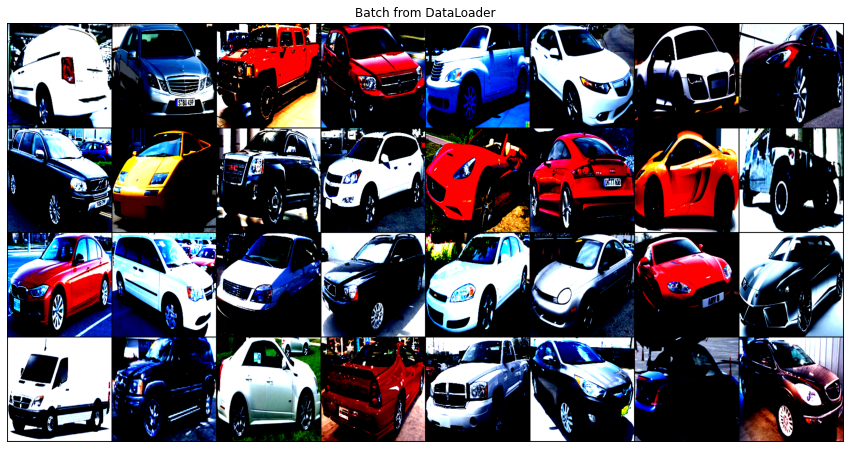

In [ ]:
for i_batch, sample_batched in enumerate(train_dataloader_res):

    if i_batch == 3:
        plt.figure(figsize=(15,8))
        show_batch(sample_batched[0])
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

Resizing the images to be 224x224 makes them look odd, but it may improve the performance since the model will be able to see more of the vehicle.

In [ ]:
# model trained on resized images of the cars
model_ft_res = models.resnet34(pretrained=True)
num_ftrs = model_ft_res.fc.in_features

model_ft_res.fc = nn.Linear(num_ftrs, len(classes)+1)

model_ft_res = model_ft_res.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft_res = optim.SGD(model_ft_res.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler_res = lr_scheduler.StepLR(optimizer_ft_res, step_size=7, gamma=0.1)

In [ ]:
model_ft_res = train_model(model_ft_res, criterion, optimizer_ft_res, exp_lr_scheduler_res, num_epochs = 25)

Epoch 0/24
---------------
train Loss: 5.0485 Acc: 0.0445

val Loss: 4.4709 Acc: 0.1351

Epoch 1/24
---------------
train Loss: 3.8749 Acc: 0.3053

val Loss: 3.4977 Acc: 0.3407

Epoch 2/24
---------------
train Loss: 2.8277 Acc: 0.5635

val Loss: 2.6649 Acc: 0.5040

Epoch 3/24
---------------
train Loss: 1.9668 Acc: 0.7606

val Loss: 2.0639 Acc: 0.6274

Epoch 4/24
---------------
train Loss: 1.3033 Acc: 0.8787

val Loss: 1.6474 Acc: 0.7041

Epoch 5/24
---------------
train Loss: 0.8376 Acc: 0.9411

val Loss: 1.3858 Acc: 0.7397

Epoch 6/24
---------------
train Loss: 0.5383 Acc: 0.9724

val Loss: 1.2125 Acc: 0.7698

Epoch 7/24
---------------
train Loss: 0.3638 Acc: 0.9913

val Loss: 1.1913 Acc: 0.7716

Epoch 8/24
---------------
train Loss: 0.3455 Acc: 0.9923

val Loss: 1.1846 Acc: 0.7698

Epoch 9/24
---------------
train Loss: 0.3349 Acc: 0.9942

val Loss: 1.1796 Acc: 0.7716

Epoch 10/24
---------------
train Loss: 0.3197 Acc: 0.9929

val Loss: 1.1557 Acc: 0.7784

Epoch 11/24
--------

It looks like resizing the images improved the accuracy from 59.3% to 77.9%, over a 15% increase! Even though the proportions of the cars are odd, resizing the images fits more discriminative features into the image. There is still the problem of overfitting though which may be remediated if we add some dropout layers and maybe batch normalization layers to the FC layer in ResNet. 

First, I would like to look at how the layers activated differently for the worst class.

In [ ]:
# loading parameters from this model to improve it
best_model_1_res_ft  = models.resnet34(pretrained=True)
num_ftrs = best_model_1_res_ft.fc.in_features
best_model_1_res_ft.fc = nn.Linear(num_ftrs, len(classes)+1)
best_model_1_res_ft = best_model_1_res_ft.to(device)

best_model_1_res_ft.load_state_dict(torch.load('./best_model_params/model_ft_res_1'))

<All keys matched successfully>

In [ ]:
gradcam_transform_res = transforms.Compose([
    transforms.Resize((224, 224))
])

gradcam_res = Gradcam(best_model_1_res_ft, dataloader=dataloaders_res)

worst_class_res, preds_res, labels_res, names_res = gradcam_res.find_worst_class('val')

gradcam_res.gradcam(target_layers=['layer4'], target_class=worst_class_res, 
                    grad_transformation=gradcam_transform_res, 
                    model_transformation=transformations_res)

The worst class is 17 or the Audi 100 Wagon 1994.


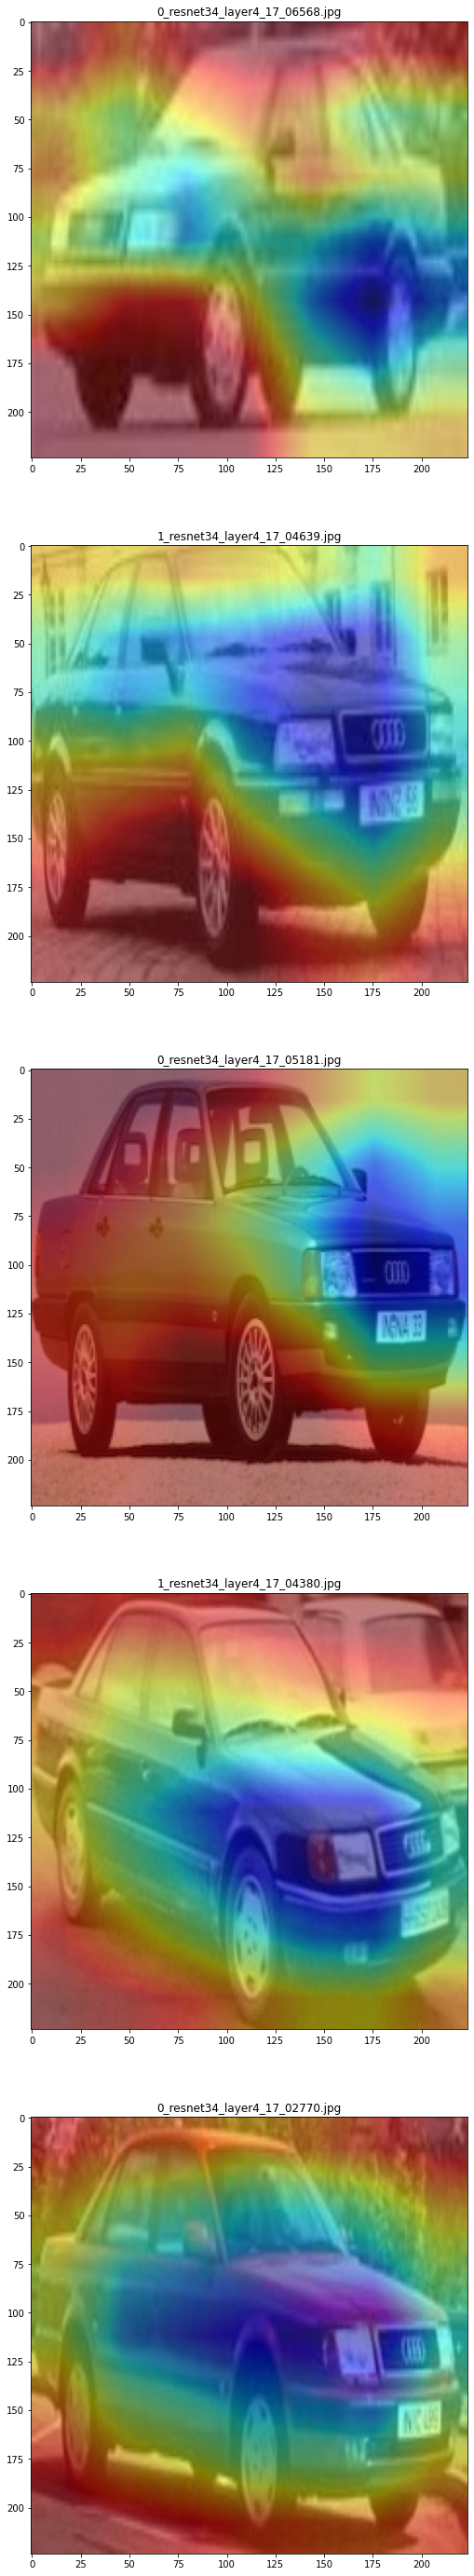

In [ ]:
heatmaps_res = loadImages(path='./heatmaps/', class_num=[17])

It looks like the CNN uses the headlights and the wheel still, but in some of the images it uses the front of the car which may include a symbol which represents the make of the car. It also uses the front window and the shape of the hood possibly. A good step up from using only lights or wheels.

## Regularizing ResNet

I want to test out if regularizing the CNN will improve it's performance before I try to tune more hyperparameters. For this model, I chose some parameters which I think would fit and ran the model a few times with different parameters for the dropout layer and the new linear layer.

In [ ]:
class ResNetRegularized(nn.Module):

  def __init__(self):

    super(ResNetRegularized, self).__init__()

    resnet = best_model_1_res_ft

    modules = list(resnet.children())[:-2]

    self.features1 = nn.Sequential(*modules[:6])
    self.features2 = nn.Sequential(*modules[6:])

    self.classifier = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(512, 500),
        nn.BatchNorm1d(500),
        nn.Dropout(0.7),
        nn.Linear(500, len(classes)+1)
    )

  def forward(self, x):

    x = self.features1(x)
    x = self.features2(x)

    # x = F.adaptive_avg_pool2d(x, 1)
    x = nn.AdaptiveAvgPool2d((1,1))(x)

    x = x.view(x.shape[0], -1)
    
    x = self.classifier(x)

    return x

In [ ]:
model_reg = ResNetRegularized().to(device)

optimizer_ft_reg = optim.SGD(best_model_1_res_ft.parameters(), lr=0.01, momentum=0.9)

exp_lr_scheduler_reg = lr_scheduler.StepLR(optimizer_ft_reg, step_size=7, gamma=0.1)

model_reg = train_model(model_reg, criterion, 
                        optimizer_ft_reg, exp_lr_scheduler_reg, 
                        dataloader=dataloaders_res, dataset_size=dataset_sizes_res, 
                        num_epochs=25)

Epoch 0/24
---------------
train Loss: 5.4932 Acc: 0.0138

val Loss: 4.7984 Acc: 0.0681

Epoch 1/24
---------------
train Loss: 4.9780 Acc: 0.0379

val Loss: 4.2924 Acc: 0.2099

Epoch 2/24
---------------
train Loss: 4.5240 Acc: 0.0895

val Loss: 3.8798 Acc: 0.3376

Epoch 3/24
---------------
train Loss: 4.1083 Acc: 0.1553

val Loss: 3.4890 Acc: 0.4340

Epoch 4/24
---------------
train Loss: 3.6615 Acc: 0.2576

val Loss: 3.2827 Acc: 0.5089

Epoch 5/24
---------------
train Loss: 3.2561 Acc: 0.3797

val Loss: 2.8363 Acc: 0.6071

Epoch 6/24
---------------
train Loss: 2.8421 Acc: 0.5015

val Loss: 2.6408 Acc: 0.6832

Epoch 7/24
---------------
train Loss: 2.4460 Acc: 0.6282

val Loss: 2.3152 Acc: 0.7575

Epoch 8/24
---------------
train Loss: 2.2769 Acc: 0.6875

val Loss: 2.2229 Acc: 0.7790

Epoch 9/24
---------------
train Loss: 2.1690 Acc: 0.7094

val Loss: 2.1666 Acc: 0.7815

Epoch 10/24
---------------
train Loss: 2.1148 Acc: 0.7342

val Loss: 2.1238 Acc: 0.7851

Epoch 11/24
--------

## Hyperparameter Tuning

I am now going to tune the hyperparameters: dropout probability, linear layer size, learning rate, gamma, and the batch size. I am using Ray Tune along with the NeverGrad search algorithm to find the best hyperparameters.

In [ ]:
# ResNet with configurable parameters for the regularizing layers
class ResNetRegularizedTuned(nn.Module):

  def __init__(self, s1=500, dp1=0.5, dp2=0.7):

    super(ResNetRegularizedTuned, self).__init__()

    resnet = best_model_1_res_ft

    modules = list(resnet.children())[:-2]

    self.features1 = nn.Sequential(*modules[:6])
    self.features2 = nn.Sequential(*modules[6:])

    self.classifier = nn.Sequential(
        nn.Dropout(dp1),
        nn.Linear(512, s1),
        nn.BatchNorm1d(s1),
        nn.Dropout(dp2),
        nn.Linear(s1, len(classes)+1)
    )

  def forward(self, x):

    x = self.features1(x)
    x = self.features2(x)

    x = nn.AdaptiveAvgPool2d((1,1))(x)

    x = x.view(x.shape[0], -1)
    
    x = self.classifier(x)

    return x

In [ ]:
# training function for Ray Tune to use 
def train_resnet(config, checkpoint_dir=os.path.abspath('./tune_chckpoints')):

  net = ResNetRegularizedTuned(config['s1'], config['dp1'], config['dp2'])

  device = 'cpu'
  if torch.cuda.is_available():
    device = 'cuda:0'
    if torch.cuda.device_count() > 1:
      net = nn.DataParallel(net)

  net.to(device)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=config['lr'], momentum=0.9)
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, 
                                             gamma=config['gamma'])

  if checkpoint_dir:
    model_state, optimizer_state = torch.load(
        os.path.join(checkpoint_dir, 'checkpoint')
    )

    net.load_state_dict(model_state)

    optimizer.load_state_dict(optimizer_state)

  train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], 
                                shuffle=True, num_workers=2)
  val_dataloader = DataLoader(val_dataset, batch_size=config['batch_size'], 
                              shuffle=True, num_workers=2)
  
  dataloader = {'train':train_dataloader,
               'val':val_dataloader}

  dataset_size = {'train': len(train),
                 'val': len(val)}
  
  # need to have training function within to report epoch acc and loss to RayTune
  num_epochs = 20
  for epoch in range(num_epochs):
      print(f'Epoch {epoch}/{num_epochs-1}')
      print('-'*15)
      
      for phase in ['train', 'val']:
          if phase == 'train':
              net.train()
          else:
              net.eval()
              
          running_loss = 0.0
          running_corrects = 0
          
          for inputs, labels, _ in dataloader[phase]:
              inputs = inputs.to(device)
              labels = labels.to(device)
              
              optimizer.zero_grad()
              
              with torch.set_grad_enabled(phase == 'train'):
                  outputs = net(inputs)
                  _, preds = torch.max(outputs, 1)
                  loss = criterion(outputs, labels)
                  
                  if phase == 'train':
                      loss.backward()
                      optimizer.step()
                
              # multiply by batch size since CrossEntropy is reduced using
              # the mean
              running_loss += loss.item() * inputs.size(0)
              running_corrects += torch.sum(preds == labels.data)
              
          if phase == 'train':
              exp_lr_scheduler.step()
              
          epoch_loss = running_loss / dataset_size[phase]
          epoch_acc = running_corrects.double() / dataset_size[phase]

          with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, 'checkpoint')
            torch.save((net.state_dict(), optimizer.state_dict()), path)

          tune.report(loss=epoch_loss, accuracy=epoch_acc)
          

In [ ]:
config = {
    's1': tune.randint(349, 501),
    'dp1': tune.choice([0.5, 0.6, 0.7, 0.8]),
    'dp2': tune.choice([0.5, 0.6, 0.7, 0.8]),
    'lr': tune.loguniform(1e-4, 1e-1),
    'gamma': tune.choice([0.1, 0.01]),
    'batch_size': tune.choice([8, 16, 32, 40])
}

scheduler = ASHAScheduler(
    metric='loss',
    mode='min',
    max_t=25,
    grace_period=1,
    reduction_factor=2
)

reporter = JupyterNotebookReporter(
    overwrite=True,
    metric_columns=['loss', 'accuracy', 'training_iteration']
)

current_best_params = [{
    's1': 500,
    'dp1': 0.5,
    'dp2': 0.7,
    'lr': 0.01,
    'gamma': 0.1,
    'batch_size': 32
}]

ng_search = NevergradSearch(
    optimizer=ng.optimizers.OnePlusOne,
    metric='loss',
    mode='min',
    points_to_evaluate=current_best_params
)

result = tune.run(
    train_resnet,
    search_alg=ng_search,
    resources_per_trial={'cpu':2, 'gpu':1},
    config=config,
    # metric='loss',
    # mode='min',
    num_samples=20,
    scheduler=scheduler
)


best_trial = result.get_best_trial('loss', 'min', 'last')
print(f'Best trial config: {best_trial.config}')
print(f'Best trial final validation loss: {best_trial.last_result["loss"] }')
print(f'Best trial final validation accuracy: {best_trial.last_result["accuracy"] } ')

Note: Unfortunately, the output was deleted since I hit the GPU limit for Colab, but the best parameters were recorded and are in my neural net below.

### Using parameters from tuning

In [ ]:
transformations_res = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

BATCH = 16

train_dataset_tune = Dataset(train, transform=transformations_res)
val_dataset_tune = Dataset(val, transform=transformations_res)

train_dataloader_tune = DataLoader(train_dataset_tune, batch_size=BATCH, shuffle=True)
val_dataloader_tune = DataLoader(val_dataset_tune, batch_size=BATCH, shuffle=True)

dataloaders_tune = {'train':train_dataloader_tune,
               'val':val_dataloader_tune}

dataset_sizes_tune = {'train': len(train),
                 'val': len(val)}

model_tune = ResNetRegularizedTuned(s1=486, dp1=0.6, dp2=0.5).to(device)

optimizer_ft_tune = optim.SGD(model_tune.parameters(), lr=0.0045, momentum=0.9)

exp_lr_scheduler_tune = lr_scheduler.StepLR(optimizer_ft_tune, step_size=7, gamma=0.1)

model_tune = train_model(model_tune, criterion, 
                        optimizer_ft_tune, exp_lr_scheduler_tune, 
                        dataloader=dataloaders_tune, dataset_size=dataset_sizes_tune, 
                        num_epochs=25)

Epoch 0/24
---------------
train Loss: 3.6268 Acc: 0.1827

val Loss: 2.0159 Acc: 0.4537

Epoch 1/24
---------------
train Loss: 2.0471 Acc: 0.4344

val Loss: 1.5219 Acc: 0.5654

Epoch 2/24
---------------
train Loss: 1.5113 Acc: 0.5595

val Loss: 1.1968 Acc: 0.6372

Epoch 3/24
---------------
train Loss: 1.0474 Acc: 0.6887

val Loss: 1.0567 Acc: 0.6943

Epoch 4/24
---------------
train Loss: 0.8440 Acc: 0.7389

val Loss: 0.9169 Acc: 0.7434

Epoch 5/24
---------------
train Loss: 0.7519 Acc: 0.7762

val Loss: 0.7987 Acc: 0.7686

Epoch 6/24
---------------
train Loss: 0.5852 Acc: 0.8187

val Loss: 0.8699 Acc: 0.7594

Epoch 7/24
---------------
train Loss: 0.3234 Acc: 0.9028

val Loss: 0.5067 Acc: 0.8570

Epoch 8/24
---------------
train Loss: 0.2484 Acc: 0.9297

val Loss: 0.4811 Acc: 0.8594

Epoch 9/24
---------------
train Loss: 0.1855 Acc: 0.9518

val Loss: 0.4816 Acc: 0.8564

Epoch 10/24
---------------
train Loss: 0.1686 Acc: 0.9552

val Loss: 0.4607 Acc: 0.8631

Epoch 11/24
--------

The final step is to see the performance on the test set. This will probably turn out worse than the accuracy for the validation set since I was improving the hyperparameters based on how the validation set performed. These hyperparameters will introduce an implicit bias for the validation set and it may not generalize well to the new test data. 

# Step 3: Evaluating on the test data

In [ ]:
# Load best model params
tuned_model = ResNetRegularizedTuned(s1=486, dp1=0.6, dp2=0.5).to(device)

tuned_model.load_state_dict(torch.load('./best_model_params/model_ft_tune'))

# Transform test data
transformations_res = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

BATCH = 16

test_dataset = Dataset(test_df, transform=transformations_res, train=False)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH, shuffle=True)

# dataloaders_tune = {'train':train_dataloader_tune,
#                'val':val_dataloader_tune}

# dataset_sizes_tune = {'train': len(train),
#                  'val': len(val)}

tuned_model.eval()

preds = []
label = []
mislabeled = []

# get predictions for dataset
for inputs, labels, _ in test_dataloader:
  
  with torch.no_grad():
    out = tuned_model(inputs.to(device))
    _, prediction = torch.max(out, 1)
    preds.append(prediction.cpu().numpy())
    label.append(labels.cpu().numpy())

pred = np.hstack(preds)
true = np.hstack(label)



In [ ]:
print(f'The model achieved an accuracy of {np.sum(pred == true)/len(test_df)} on the test set.')

The model achieved an accuracy of 0.8722795672180077 on the test set.


# Conclusion

Overall, I was able to improve the accuracy of the model by 18%. I achieved this through using GradCAM to see how the layers were activating and resizing the images. Also by regularizing ResNet by using two dropout layers and a batch norm layer in the last fully connected layer of the CNN. This is a significant improvement over the baseline model and I achieved my goal of improving ResNet for the cars dataset.

I believe that resizing the images could have been achieved without using ResNet and more of an educated guess, but using GradCAM I was able to visualize how the model was behaving and quantitatively show that resizing the images brings more information into the image and allows the model to learn more discriminative features through the hood or the shape of the front window. 

Adding the regularizing layers to the model may not mean that it is a pure ResNet model, however, I believe that this approach is a viable option for a realistic problem in which transfer learning gives a headstart, but the model needs some tweaking.

In terms of improvement, I think increasing the number of epochs may help improve the model, but it usually begins to overfit around 10 epochs so increasing the epochs may just cause the model to become too biased. I think the code could be improved through some refactoring by creating some functions for model training, but this was a good start to iteratively find how to improve the model.